# PREPARACIÓN NOTEBOOK
---

## Librerías

In [1]:
from google.colab import drive
import sys
import os
import sqlite3 as sql #Crear y trabajar bases de datos ligeras
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder

## Conexión con la BD y el repositorio en Drive

In [2]:
#Conectar al drive local
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Conectar al repositorio
path = '/content/drive/My Drive/cod/A3_marketing'

sys.path.append(path) #Importar las funciones propias a través de import, porque incluye la carpeta del repositorio como uno de esos paquetes para que import busque funciones
os.chdir(path) #Subir y descargar archivos de la ruta del repositorio de trabajo

## Conexión al notebook de funciones

In [4]:
%run a_funciones.ipynb

# SQL
---

## Conexión

In [5]:
con = sql.connect('data/db_movies_c1') #Conectarse a la base de datos existente y transportar datos
cur = con.cursor() #Otra conexión (cursor) para ejecutar las consultas en la bd sin traer ni llevar info

In [6]:
#Consultar qué tablas disponibles tiene la bd
cur.execute(""" select name from sqlite_master where type= 'table' """)
cur.fetchall()

[('ratings',), ('movies',), ('movies_clean',), ('full_ratings',)]

## Exploración

In [ ]:
tablas_a_explorar = ['ratings', 'movies']
for tabla in tablas_a_explorar:
    explorar_tabla(con, tabla)

------------

Explorando la tabla 'ratings'

Esquema de la tabla 'ratings':
  - Nombre: userId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: movieId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: rating, Tipo: REAL, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: timestamp, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0

Primeras 10 filas de la tabla 'ratings':
(1, 1, 4.0, 964982703)
(1, 3, 4.0, 964981247)
(1, 6, 4.0, 964982224)
(1, 47, 5.0, 964983815)
(1, 50, 5.0, 964982931)
(1, 70, 3.0, 964982400)
(1, 101, 5.0, 964980868)
(1, 110, 4.0, 964982176)
(1, 151, 5.0, 964984041)
(1, 157, 5.0, 964984100)

Número total de filas en 'ratings': 100836
------------

Explorando la tabla 'movies'

Esquema de la tabla 'movies':
  - Nombre: movieId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: title, Tipo: TEXT, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: genres, Tipo: TEXT, ¿Nulo?: 0, Clave Primaria: 0

Primeras 10 filas de la tabla 'movies':
(1, 'Toy Story (1995)', 'Adventure|Anim

## Exploración profunda: Tabla ratings



In [ ]:
try:
    # 1. Conteo de usuarios únicos
    cur.execute("SELECT COUNT(DISTINCT userId) FROM ratings;")
    num_usuarios_unicos = cur.fetchone()[0]
    print(f"Número de usuarios únicos: {num_usuarios_unicos}")

    # 2. Medidas estadísticas
    cur.execute("SELECT AVG(rating), MIN(rating), MAX(rating) FROM ratings;")
    promedio_rating, min_rating, max_rating = cur.fetchone()
    print(f"Promedio de rating: {promedio_rating:.2f}")
    print(f"Rating mínimo: {min_rating}")
    print(f"Rating máximo: {max_rating}")

    # 3. Moda
    cur.execute("SELECT rating FROM ratings;")
    ratings = [row[0] for row in cur.fetchall()]
    if ratings:
        moda_rating = calcular_moda(ratings)
        print(f"Moda del rating: {moda_rating}")
    else:
        print("No hay ratings para calcular la moda.")

except sql.Error as e:
    print(f"Error al explorar la tabla 'ratings': {e}")

Número de usuarios únicos: 610
Promedio de rating: 3.50
Rating mínimo: 0.5
Rating máximo: 5.0
Moda del rating: 4.0


## Exploración profunda: Tabla movies

Para esta exploración se usara la librería de pandas ya que permite una manipulación mas rápida y menos engorrosa de la tabla al realizar los split's y extracciones de fragmentos de la cadena de texto mas rápidamente

In [ ]:
#Separación en columnas de los generos

movies=pd.read_sql('select * from movies', con)
genres=movies['genres'].str.split('|')
te = TransactionEncoder()
genres = te.fit(genres).transform(genres)
genres =pd.DataFrame(genres, columns=te.columns_)
len(movies['genres'].unique())
genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
9738,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
9739,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
9740,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
movies_con_generos = pd.concat([movies, genres], axis=1)
movies_con_generos = movies_con_generos.drop(columns='genres')
movies_con_generos = movies_con_generos.astype({col: int for col in movies_con_generos.columns if movies_con_generos[col].dtype == 'bool'})
movies_con_generos.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 1. Extraer el año (4 dígitos) de cualquier paréntesis
year = movies_con_generos['title'].str.extract(r'\((\d{4})\)')[0]

# Convertir a entero nullable
movies_con_generos['year'] = year.astype('Int64')

# 2. Quitar cualquier "(YYYY)" del título
movies_con_generos['title'] = (
    movies_con_generos['title']
        .str.replace(r'\s*\(\d{4}\)', '', regex=True)
        .str.strip()
)

In [ ]:
generos = [col for col in movies_con_generos.columns if col not in ['movieId', 'title', 'year']]
movies_con_generos = movies_con_generos[['movieId', 'title', 'year'] + generos]

In [ ]:
movies_con_generos

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,2017,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero,2017,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple,2018,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Guardar el DataFrame como una tabla SQL llamada 'movies_clean'
movies_con_generos.to_sql('movies_clean', con, if_exists='replace', index=False)
pd.read_sql("SELECT * FROM movies_clean LIMIT 5", con)

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# contar las películas sin género
conteo = pd.read_sql("""
    SELECT COUNT(*) AS sin_genero
    FROM movies_clean
    WHERE "(no genres listed)" = 1
""", con)

conteo

,sin_genero
0,34


In [ ]:
# # contar las películas sin género (otra forma)
# pd.read_sql("""WITH t1 AS (SELECT "(no genres listed)", COUNT(*) AS cnt
#         FROM movies_clean
#         WHERE "(no genres listed)" = 1
#         GROUP BY "(no genres listed)")
#         SELECT cnt AS sin_genero FROM t1""", con)

In [ ]:
# obtener los detalles de las películas sin género
pd.read_sql("""
    SELECT movieId, title, year
    FROM movies_clean
    WHERE "(no genres listed)" = 1
    ORDER BY year, title
""", con)

,movieId,title,year
0,176601,Black Mirror,NaN
1,171495,Cosmos,NaN
2,171749,Death Note: Desu nôto (2006–2007),NaN
3,171891,Generation Iron 2,NaN
4,143410,Hyena Road,NaN
5,171631,Maria Bamford: Old Baby,NaN
6,156605,Paterson,NaN
7,147250,The Adventures of Sherlock Holmes and Doctor W...,NaN
8,167570,The OA,NaN
9,114335,La cravate,1957.0


In [ ]:
# obtener los detalles de las películas sin año
pd.read_sql("""
    SELECT movieId, title, year
    FROM movies_clean
    WHERE year IS NULL
    ORDER BY title
""", con)

,movieId,title,year
0,40697,Babylon 5,None
1,176601,Black Mirror,None
2,171495,Cosmos,None
3,171749,Death Note: Desu nôto (2006–2007),None
4,171891,Generation Iron 2,None
5,143410,Hyena Road,None
6,171631,Maria Bamford: Old Baby,None
7,162414,Moonlight,None
8,149334,Nocturnal Animals,None
9,156605,Paterson,None


In [ ]:
# contar películas por año
tabla_conteo = pd.read_sql("""
    SELECT year AS Año, COUNT(*) AS "Cantidad de películas"
    FROM movies_clean
    WHERE year IS NOT NULL
    GROUP BY year
    ORDER BY year
""", con)

In [ ]:
# graficar conteo de películas por año
fig = px.bar(tabla_conteo,
             x='Año',
             y='Cantidad de películas',
             title='Cantidad de películas por año',
             labels={'Año': 'Año', 'Cantidad de películas': 'Número de películas'})

# Personalizar las etiquetas del eje x para mostrar solo cada 5 años
years = tabla_conteo['Año'].tolist()
if years:
    tickvals = years[::5]
    ticktext = [str(year) for year in years[::5]]
    fig.update_layout(xaxis=dict(tickmode='array',
                                 tickvals=tickvals,
                                 ticktext=ticktext,
                                 tickangle=90))

fig.show()

La gráfica muestra la evolución de la cantidad de películas producidas por año desde 1902 hasta 2018. Entre las décadas de 1900 y 1920, la producción cinematográfica fue baja y relativamente estable, reflejando los inicios de la industria del cine. A partir de la década de 1970 se observa un crecimiento más marcado, que se intensifica notablemente entre las décadas de 1990 y 2010, alcanzando su punto máximo alrededor del año 2002 con más de 300 películas anuales.

In [ ]:
# Distribución por década
conteo_decadas = pd.read_sql("""
    SELECT
        (year / 10) * 10 AS decada,
        COUNT(*) AS cantidad
    FROM movies_clean
    WHERE year IS NOT NULL
    GROUP BY decada
    ORDER BY decada
""", con)

conteo_decadas

,decada,cantidad
0,1900,3
1,1910,7
2,1920,37
3,1930,136
4,1940,197
5,1950,279
6,1960,401
7,1970,500
8,1980,1177
9,1990,2212


In [ ]:
# Cantidad de películas por género
conteo_generos = pd.read_sql("""
    SELECT
        SUM("Action") AS Action,
        SUM("Adventure") AS Adventure,
        SUM("Animation") AS Animation,
        SUM("Children") AS Children,
        SUM("Comedy") AS Comedy,
        SUM("Crime") AS Crime,
        SUM("Documentary") AS Documentary,
        SUM("Drama") AS Drama,
        SUM("Fantasy") AS Fantasy,
        SUM("Film-Noir") AS "Film-Noir",
        SUM("Horror") AS Horror,
        SUM("IMAX") AS IMAX,
        SUM("Musical") AS Musical,
        SUM("Mystery") AS Mystery,
        SUM("Romance") AS Romance,
        SUM("Sci-Fi") AS "Sci-Fi",
        SUM("Thriller") AS Thriller,
        SUM("War") AS War,
        SUM("Western") AS Western
    FROM movies_clean
""", con)

conteo_generos.T.sort_values(by=0, ascending=False).rename(columns={0: 'cantidad'})

,cantidad
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978
Fantasy,779


In [ ]:
# Transformar el DataFrame para graficar
conteo_generos_df = conteo_generos.T.sort_values(by=0, ascending=False).rename(columns={0: 'cantidad'})
conteo_generos_df = conteo_generos_df.reset_index().rename(columns={'index': 'género'})

# Crear gráfica
fig = px.bar(conteo_generos_df,
             x='género',
             y='cantidad',
             title='Cantidad de películas por género',
             labels={'género': 'Género', 'cantidad': 'Número de películas'},
             text='cantidad')

fig.update_layout(xaxis_tickangle=45)
fig.show()

In [ ]:
# Películas con múltiples géneros
conteo_generos_por_pelicula = pd.read_sql("""
    SELECT
        movieId,
        title,
        year,
        (
            "Action" + "Adventure" + "Animation" + "Children" +
            "Comedy" + "Crime" + "Documentary" + "Drama" +
            "Fantasy" + "Film-Noir" + "Horror" + "IMAX" +
            "Musical" + "Mystery" + "Romance" + "Sci-Fi" +
            "Thriller" + "War" + "Western"
        ) AS n_genres
    FROM movies_clean
""", con)

conteo_generos_por_pelicula.head()

,movieId,title,year,n_genres
0,1,Toy Story,1995.0,5
1,2,Jumanji,1995.0,3
2,3,Grumpier Old Men,1995.0,2
3,4,Waiting to Exhale,1995.0,3
4,5,Father of the Bride Part II,1995.0,1


# PANDAS

In [ ]:
#Crear df's de pandas con las tablas
df_ratings = pd.read_sql('select * from ratings', con)
df_movies = pd.read_sql('select * from movies', con)

## Exploración de df_ratings

In [ ]:
#Visualización de df_ratings
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
#Renombrar columnas del df e indexarlo con movie_id
df_ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df_ratings = df_ratings.set_index('movie_id')
df_ratings

,user_id,rating,timestamp
movie_id,,,
1,1,4.0,964982703
3,1,4.0,964981247
6,1,4.0,964982224
47,1,5.0,964983815
50,1,5.0,964982931
...,...,...,...
166534,610,4.0,1493848402
168248,610,5.0,1493850091
168250,610,5.0,1494273047


In [ ]:
#La columna 'fecha_vista' es en realidad un unix timestamp, es decir, el número de segundos desde el 1 de enero de 1970 (UTC). Se restructura.
df_ratings['fecha_vista'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings

,user_id,rating,timestamp,fecha_vista
movie_id,,,,
1,1,4.0,964982703,2000-07-30 18:45:03
3,1,4.0,964981247,2000-07-30 18:20:47
6,1,4.0,964982224,2000-07-30 18:37:04
47,1,5.0,964983815,2000-07-30 19:03:35
50,1,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...
166534,610,4.0,1493848402,2017-05-03 21:53:22
168248,610,5.0,1493850091,2017-05-03 22:21:31
168250,610,5.0,1494273047,2017-05-08 19:50:47


## Exploración de df_movies

In [ ]:
#Visualización de df_movies
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#Renombrar columnas del df e indexarlo por movie_id
df_movies.columns = ['movie_id', 'titulo', 'genero']
df_movies = df_movies.set_index('movie_id')
df_movies

,titulo,genero
movie_id,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


# Exploracion de insights

A continuacion se realizara una serie de consultas SQL con el fin de extraer insights clave del dataset de movies y ratings. Se busca conocer el comportamiento de los usuarios, identificar patrones de calificacion y preparar el entendimiento del negocio antes del modelado

In [ ]:
#Crear df's de pandas con las tablas
df_ratings = pd.read_sql('select * from ratings', con)
df_movies = pd.read_sql('select * from movies', con)

In [ ]:
# 1. Cantidad total de peliculas y usuarios unicos
cur.execute("SELECT COUNT(DISTINCT movieId), COUNT(DISTINCT userId) FROM ratings;")
total_peliculas, total_usuarios = cur.fetchone()
print(f"Total de peliculas: {total_peliculas}")
print(f"Total de usuarios: {total_usuarios}")

Total de peliculas: 9724
Total de usuarios: 610


In [ ]:
# 2. Top 10 peliculas con mas valoraciones
cur.execute("""
    SELECT r.movieId, m.title, COUNT(*) AS total_valoraciones
    FROM ratings r
    JOIN movies m ON r.movieId = m.movieId
    GROUP BY r.movieId, m.title
    ORDER BY total_valoraciones DESC
    LIMIT 10;
""")
top_movies = cur.fetchall()
print("\nTop 10 peliculas con mas valoraciones:")
for movie in top_movies:
    print(f"{movie[1]} - {movie[2]} valoraciones")


Top 10 peliculas con mas valoraciones:
Forrest Gump (1994) - 329 valoraciones
Shawshank Redemption, The (1994) - 317 valoraciones
Pulp Fiction (1994) - 307 valoraciones
Silence of the Lambs, The (1991) - 279 valoraciones
Matrix, The (1999) - 278 valoraciones
Star Wars: Episode IV - A New Hope (1977) - 251 valoraciones
Jurassic Park (1993) - 238 valoraciones
Braveheart (1995) - 237 valoraciones
Terminator 2: Judgment Day (1991) - 224 valoraciones
Schindler's List (1993) - 220 valoraciones


- Las 10 peliculas con mas valoraciones en el dataset son de los años 1990 a 1999

In [ ]:
# 3. Distribucion de calificaciones
cur.execute("""
    SELECT rating, COUNT(*) as conteo
    FROM ratings
    GROUP BY rating
    ORDER BY rating
""")

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.0]
#plt.hist(df_ratings['rating'], bins=bins, edgecolor='black', color='skyblue')
#plt.xticks(bins)
#plt.title('Distribucion de calificaciones')
#plt.xlabel('Calificacion')
#plt.ylabel('Frecuencia')
#plt.show()

fig1 = px.histogram(df_ratings,
                   x='rating',
                   title='Distribucion de calificaciones',
                   labels={'rating': 'Calificacion', 'count': 'Frecuencia'},
                   histnorm='', # No aplicar normalización por defecto
                   range_x=[min(bins), max(bins)], # Establecer el rango del eje x
                   nbins=len(bins) - 1, # Definir el número de bins
                   category_orders={'rating': [str(b) for b in bins[:-1]]}) # Asegurar el orden de las etiquetas

# Personalizar el fondo y eliminar las líneas de los ejes
fig1.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig1.update_traces(marker=dict(line=dict(width=1, color='black')),
                  marker_color='skyblue')

fig1.update_layout(xaxis=dict(tickvals=bins))

fig1.show()

 El histograma muestra que la mayoria de las calificaciones se concentran entre 3.0 y 4.0 con un pico en la calificaicón 4.0, lo cual indica una tendencia positiva en la percepcion de las peliculas por parte de los usuarios. Las calificaciones bajas, entre 0 a 2.5, son menos frecuentes, lo que nos podria decir que los usuarios tienden a valorar mas positivamente las peliculas.

In [ ]:
# 4. Numero de calficaciones por usuario
cur.execute("""
    SELECT userId, COUNT(*) as cnt_rating
    FROM ratings
    GROUP BY userId
""")
user_ratings = pd.DataFrame(cur.fetchall(), columns=['userId', 'cnt_rating'])

#plt.hist(user_ratings['cnt_rating'], bins=30, color='lightcoral', edgecolor='black')
#plt.title('Numero de calificaciones por usuario')
#plt.xlabel('Cantidad de calificaciones')
#plt.ylabel('Frecuencia de usuarios')
#plt.show()

fig2 = px.histogram(user_ratings,
                   x='cnt_rating',
                   nbins=30,
                   title='Numero de calificaciones por usuario',
                   labels={'cnt_rating': 'Cantidad de calificaciones', 'count': 'Frecuencia de usuarios'})

fig2.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

fig2.show()

Mediante el gráfico de barras podemos observar que el pico de calificaciones por usuario en la plataforma está entre 0 y 99. De 100 calificaciones por usuario en adelante vemos una drastica reducción hasta llegar el maximo de un solo usuario con un total de entre 2600 a 2699 peliculas calificadas.


In [ ]:
# Crear un DataFrame con usuarios que tienen entre 30 y 500 calificaciones
usuarios_filtrados = pd.read_sql('''
    SELECT "userId" AS usuario,
           COUNT(*) AS cnt_rat
    FROM ratings
    GROUP BY "userId"
    HAVING cnt_rat BETWEEN 30 AND 500
    ORDER BY cnt_rat ASC
''', con)

#plt.figure(figsize=(8, 6))
#plt.hist(usuarios_filtrados['cnt_rat'], bins=30, color='teal', edgecolor='black')
#plt.title('Distribución de usuarios con 30 a 500 calificaciones')
#plt.xlabel('Cantidad de calificaciones')
#plt.ylabel('Frecuencia')
#plt.grid(True)
#plt.show()

fig3 = px.histogram(usuarios_filtrados,
                   x='cnt_rat',
                   nbins=15,
                   title='Distribución de usuarios con 30 a 500 calificaciones',
                   labels={'cnt_rat': 'Cantidad de calificaciones', 'count': 'Frecuencia de usuarios'})

fig3.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

fig3.show()

El grafico muestra que dentro del rango filtrado de usuarios que realizaron entre 30 y 500 calificaciones, la mayoria esta en el segmento inferior, con un pico entre los 50 y 99 registros aproximadamente. A medida que aumenta la cantidad de calificaciones por usuario, la frecuencia disminuye considerablemente, lo que evidencia que aunque hay usuarios activos la gran mayoria tiene una participación moderada a la hora de valorar las peliculas.

In [ ]:
# 6. Numero de calificaciones por pelicula
cur.execute("""
    SELECT movieId, COUNT(*) as cnt_rating
    FROM ratings
    GROUP BY movieId
""")
movie_ratings = pd.DataFrame(cur.fetchall(), columns=['movieId', 'cnt_rating'])

#plt.hist(movie_ratings['cnt_rating'], bins=30, color='orange', edgecolor='black')
#plt.title('Numero de calificaciones por pelicula')
#plt.xlabel('Cantidad de calificaciones')
#plt.ylabel('Numero de peliculas')
#plt.show()

fig4 = px.histogram(movie_ratings,
                   x='cnt_rating',
                   nbins=30,
                   title='Numero de calificaciones por pelicula',
                   labels={'cnt_rating': 'Cantidad de calificaciones', 'count': 'Numero de peliculas'})

fig4.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig4.show()

El histograma muestra que la gran mayoria de las peliculas han recibido muy pocas calificaciones, concentrandose principalmente entre 0 y 20. Muy pocas peliculas han sido valoradas por muchos usuarios. Esto puede ser debido a una desigualdad en cuanto a la popularidad de estas

In [ ]:
# películas con entre 20 y 120 calificaciones
query = """
    SELECT movieId, COUNT(*) AS cnt_rating
    FROM ratings
    GROUP BY movieId
    HAVING cnt_rating BETWEEN 20 AND 120
"""
movie_ratings_filtrado = pd.read_sql(query, con)

In [ ]:
fig = px.histogram(movie_ratings_filtrado,
                   x='cnt_rating',
                   nbins=20,
                   title='Número de calificaciones por película (entre 20 y 120)',
                   labels={'cnt_rating': 'Cantidad de calificaciones', 'count': 'Número de películas'})

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

fig.show()

In [ ]:
# Extraer el año y convertirlo a entero
df_movies['Year'] = pd.to_numeric(df_movies['title'].str.extract(r'\((\d{4})\)')[0], errors='coerce')
df_movies = df_movies.dropna(subset=['Year'])
df_movies['Year'] = df_movies['Year'].astype(int)

# Unir y agrupar
df_merged = pd.merge(df_ratings, df_movies[['movieId', 'Year']], on='movieId')
df_merged['Decada'] = (df_merged['Year'] // 10) * 10

# Asegurar tipo entero
df_merged['Decada'] = df_merged['Decada'].astype(int)

# Agrupar y ordenar
avg_ratings_per_group = df_merged.groupby('Decada', as_index=False)['rating'].mean().sort_values('Decada')

# Plotly interactivo con eje X limpio
import plotly.express as px

fig = px.bar(
    avg_ratings_per_group,
    x='Decada',
    y='rating',
    labels={'Decada': 'Década', 'rating': 'Promedio de Calificación'},
    title='Promedio de Calificaciones por Década',
    text='rating',
    color='rating',
    color_continuous_scale='Greens'
)

# Mejora visual
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=avg_ratings_per_group['Decada'].min(),
        dtick=10
    ),
    yaxis=dict(range=[0, 5]),
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()

<ipython-input-40-196b561be0e1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Se observa que las películas estrenadas en las décadas de 1940 y 1950 obtuvieron los promedios más altos, con calificaciones de 3.87 y 3.85 respectivamente, lo que podría reflejar una época de consolidación artística y narrativa en el cine. A partir de la década de 1960, las calificaciones comienzan a mostrar una leve disminución, destacando un descenso más notorio desde la década 80 en adelante. Las décadas de 1990, 2000 y 2010 presentan los promedios más bajos, con valores cercanos a 3.4, lo cual podría estar relacionado con el aumento en la cantidad de producciones, la diversificación de contenidos o un cambio en los criterios de evaluación por parte del público.

In [ ]:
def consultar_rating_con_titulo(con, rating=5, graficar=False):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Consulta SQL para traer ratings del valor dado y títulos de películas
    query = f"""
        SELECT r.movieId, m.title, r.rating
        FROM ratings r
        JOIN movies m ON r.movieId = m.movieId
        WHERE r.rating = {rating}
    """
    df_rating = pd.read_sql(query, con)

    # Verificar si se encontraron resultados
    if df_rating.empty:
        print(f"No se encontraron películas con calificación {rating}.")
        return

    # Mostrar conteo por película
    conteo = df_rating['title'].value_counts().reset_index()
    conteo.columns = ['Título de la película', f'Cantidad de calificaciones = {rating}']

    print(f"\nTop películas con calificación = {rating}:")
    display(conteo.head(20))

    # Graficar
    if graficar:
        plt.figure(figsize=(10, 5))
        conteo.head(10).plot(kind='barh', x='Título de la película',
                             y=f'Cantidad de calificaciones = {rating}',
                             color='mediumseagreen', edgecolor='black', legend=False)
        plt.title(f"Top 10 películas con calificación {rating}")
        plt.xlabel('Cantidad de calificaciones')
        plt.ylabel('Título de la película')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


Top películas con calificación = 2:


,Título de la película,Cantidad de calificaciones = 2
0,Ace Ventura: Pet Detective (1994),27
1,Ace Ventura: When Nature Calls (1995),25
2,Batman Forever (1995),22
3,"Nutty Professor, The (1996)",20
4,Star Wars: Episode I - The Phantom Menace (1999),20
5,Waterworld (1995),19
6,True Lies (1994),17
7,Independence Day (a.k.a. ID4) (1996),17
8,Dumb & Dumber (Dumb and Dumber) (1994),16
9,Batman & Robin (1997),16


<Figure size 1000x500 with 0 Axes>

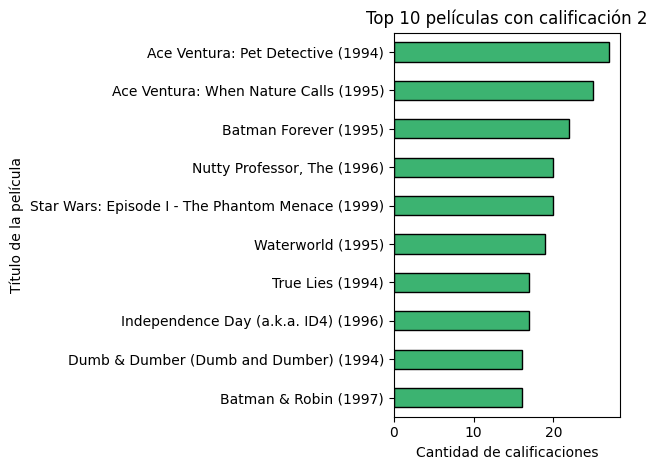

In [ ]:
consultar_rating_con_titulo(con, rating=2, graficar=True)

In [ ]:
# Crear DataFrame con películas que tienen género y más de 10 calificaciones, incluyendo las calificaciones (peliculas con rating entre 4 y 5)
df_peliculas_filtradas = pd.read_sql("""
    SELECT m.movieId, m.title, m.year,
           m."Action", m."Adventure", m."Animation", m."Children", m."Comedy", m."Crime",
           m."Film-Noir", m."Horror", m."IMAX", m."Musical", m."Mystery", m."Romance",
           m."Sci-Fi", m."Thriller", m."War", m."Western",
           AVG(r.rating) AS avg_rating,
           COUNT(r.rating) AS num_ratings
    FROM movies_clean m
    JOIN ratings r ON m.movieId = r.movieId
    WHERE m."(no genres listed)" = 0
      AND r.rating BETWEEN 4 AND 5
    GROUP BY m.movieId, m.title, m.year
    HAVING COUNT(r.rating) > 10
""", con)

df_peliculas_filtradas

,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Film-Noir,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,avg_rating,num_ratings
0,1,Toy Story,1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.380952,147
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4.210000,50
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,4.333333,18
3,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,4.291667,12
4,6,Heat,1995,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,4.405797,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,152081,Zootopia,2016,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.326087,23
1100,164179,Arrival,2016,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4.411765,17
1101,166528,Rogue One: A Star Wars Story,2016,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4.421053,19
1102,168252,Logan,2017,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4.525000,20


In [ ]:
# Guardar el DataFrame como una tabla SQL
df_peliculas_filtradas.to_sql('full_ratings', con, if_exists='replace', index=False)

1104

In [ ]:
movies_con_generos.to_sql('movies_clean', con, if_exists='replace', index=False)